In [1]:
import sys
sys.path.append("./src/")

In [2]:
import numpy as np
import torch
import pandas as pd

import reciprocalspaceship as rs

from vae_networks import VAE

/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/minhuan/mambaforge/envs/scf_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read in data and standardize

In [3]:
aniso_intersection = pd.read_pickle("../../../phyllis/PTP1B_DK/scaled_reindexed_mtzs/intersection.pkl") 
aniso_union = pd.read_pickle("../../../phyllis/PTP1B_DK/scaled_reindexed_mtzs/union.pkl")

In [4]:
def standardize(i):
    i_mean = np.nanmean(i, axis=0)
    i_std = np.nanstd(i, axis=0)
    return (i - i_mean)/i_std, i_mean, i_std

In [5]:
y_data_unnormalized = aniso_union.to_numpy().T
y_data_normalized, y_data_mean, y_data_std = standardize(y_data_unnormalized)
y_data_normalized = y_data_normalized.astype(np.float32)

/tmp/ipykernel_15218/2605283992.py:4: RuntimeWarning: invalid value encountered in divide
  return (i - i_mean)/i_std, i_mean, i_std


In [6]:
aniso_union['mean'] = y_data_mean
aniso_union['std'] = y_data_std

In [7]:
x_data_unnormalized = aniso_intersection.to_numpy().T
x_data_mean = aniso_union["mean"][aniso_intersection.index].to_numpy()
x_data_std = aniso_union["std"][aniso_intersection.index].to_numpy()
x_data_normalized = (x_data_unnormalized - x_data_mean)/x_data_std

### PCA visualization

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

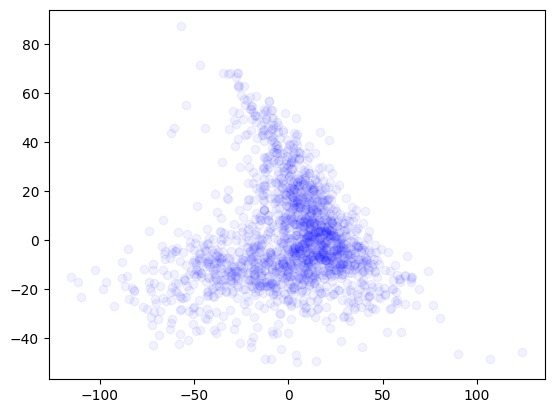

In [38]:
# inputs
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_data_normalized)
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c='blue', alpha=0.05)
plt.show()

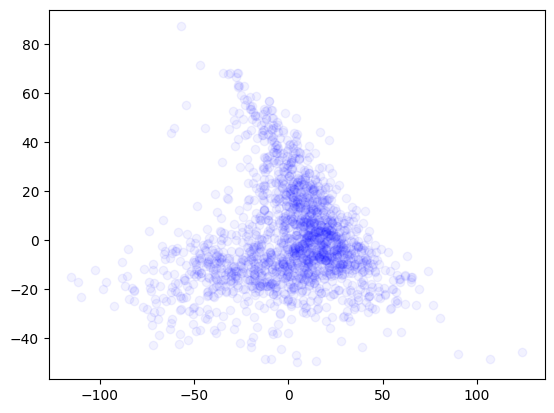

In [39]:
# outputs
output_for_pca = pd.DataFrame(y_data_normalized).dropna(axis=1)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(output_for_pca)
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c='blue', alpha=0.05)
plt.show()

### VAE Training

In [9]:
vae = VAE(n_dim_i = x_data_normalized.shape[1], 
          n_dim_o = y_data_normalized.shape[1], 
          n_dim_latent = 3, 
          n_hidden_layers = [3, 6], 
          n_hidden_size = 100, 
          activation = torch.tanh)

In [10]:
# Split train and test
choice = np.random.choice(x_data_normalized.shape[0], 1300, replace=False)    
train_ind = np.zeros(x_data_normalized.shape[0], dtype=bool)
train_ind[choice] = True
test_ind = ~train_ind

x_train, x_val = x_data_normalized[train_ind], x_data_normalized[test_ind]
y_train, y_val = y_data_normalized[train_ind], y_data_normalized[test_ind]

In [11]:
# Convert to tensor
x_train, x_val, y_train, y_val = torch.tensor(x_train), torch.tensor(x_val), torch.tensor(y_train), torch.tensor(y_val)

In [12]:
# train vae
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
vae.train(x_train, y_train, optimizer, x_val, y_val, epochs=100, batch_size=100, w_kl=1.0)

Epoch 100: 100%|██████████| 13/13 [00:01<00:00, 12.21it/s, Testloss=4.62e+4, Trainloss=4.56e+4, memory=0.418]


### Save and Load

In [13]:
vae.save('./latent-dim-3-may8-Epcoh100.pkl')

In [14]:
vae = VAE.load("./latent-dim-3-may8-Epcoh100.pkl")

In [15]:
loss_array = np.array(vae.loss_train)

In [16]:
loss_array.shape

(1300, 6)

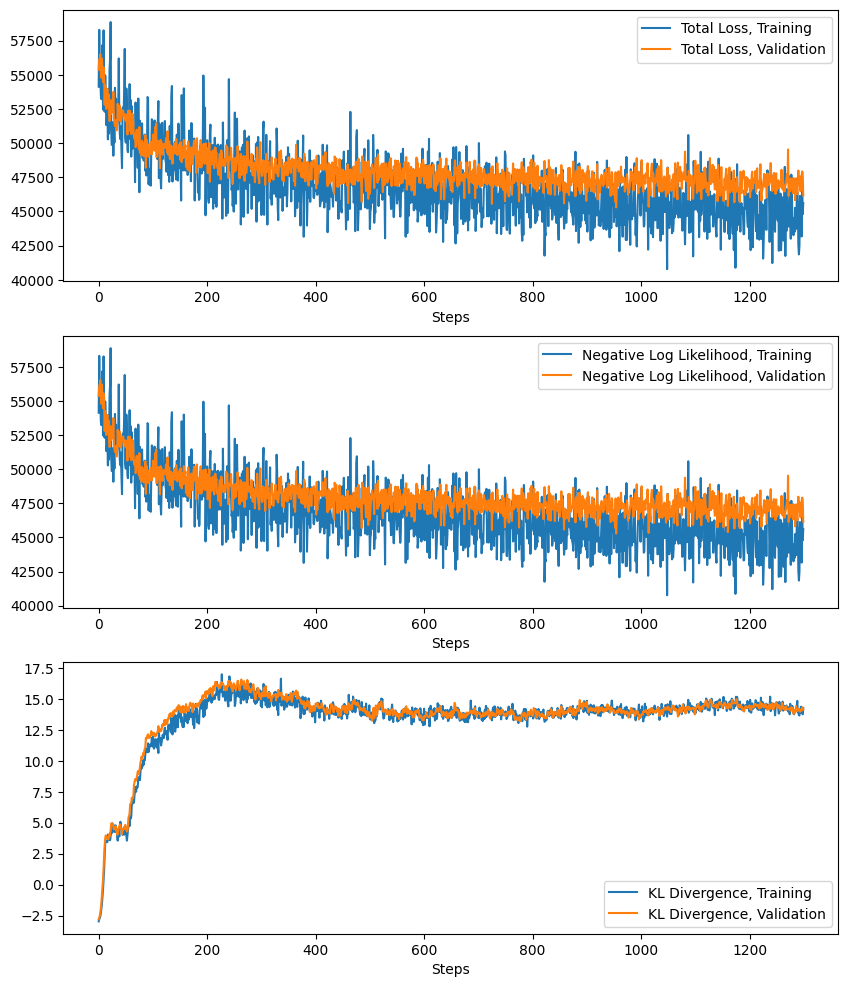

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[10,12])
ax = axs.reshape(-1)

ax[0].plot(loss_array[:,0], label='Total Loss, Training')
ax[0].plot(loss_array[:,3], label='Total Loss, Validation')
ax[0].set_xlabel("Steps")
ax[0].legend()

ax[1].plot(loss_array[:,1], label='Negative Log Likelihood, Training')
ax[1].plot(loss_array[:,4], label='Negative Log Likelihood, Validation')
ax[1].set_xlabel("Steps")
ax[1].legend()

ax[2].plot(loss_array[:,2], label='KL Divergence, Training')
ax[2].plot(loss_array[:,5], label='KL Divergence, Validation')
ax[2].set_xlabel("Steps")
ax[2].legend()


plt.show()

### Reconstruction

In [18]:
y_recons_normalized = vae.reconstruct(torch.tensor(x_data_normalized))

In [24]:
y_recons_intersection = y_recons_normalized[:, ~(np.isnan(y_data_normalized).any(axis=0))].detach().cpu().numpy()

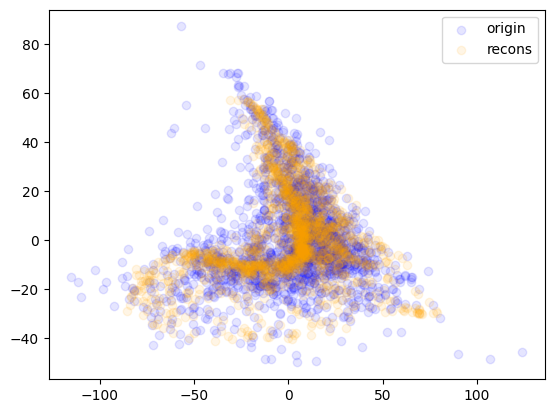

In [37]:
# outputs
output_for_pca = pd.DataFrame(y_data_normalized).dropna(axis=1).to_numpy()
pca = PCA(n_components=2)
pc_origin = pca.fit_transform(output_for_pca)
pc_recons = pca.transform(y_recons_intersection)
plt.scatter(pc_origin[:, 0], pc_origin[:, 1], c='blue', alpha=0.1, label="origin")
plt.scatter(pc_recons[:, 0], pc_recons[:, 1], c='orange', alpha=0.1, label="recons")
plt.legend()
plt.show()